# Deel II. Deep learning

## Hoofdstuk 4. Multinomiale classificatie

1. [Inleiding](#Inleiding)
2. [Multinomiale classificatie](#Multinomiale_classificatie)
3. [Softmax](#Softmax)
4. [Cross-entropy](#Cross_entropy)

### <a id='Inleiding'>Inleiding</a>

Dit is het Jupyter Notebook behorende bij hoofdstuk 4 van het vak *Advanced Datamining* (BFVH4DMN2). Op BlackBoard tref je eveneens een module `data.py` aan die diverse functies bevat die helpen bij het genereren en het visualiseren van de gebruikte datasets. Kopieer het bestand `model.py` van het vorige hoofdstuk en sla deze bestanden gezamenlijk op in één werkmap. Open je `model` module in een code-editor naar keuze om hiermee verder te werken.

Eerst zetten we weer wat initialisatie op en importeren we naast de `data` en `model` modules enkele onderdelen van `pandas`, `numpy` en `tensorflow`. Plaats de cursor in de cel hieronder en druk op Ctrl+Enter (of Shift+Enter om meteen naar de volgende cel te gaan).

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from sys import version
print(f'Using python version {version.split(" ")[0]}')

from pandas import DataFrame, __version__
print(f'Using pandas version {__version__}')

from numpy import array, __version__
print(f'Using numpy version {__version__}')

from tensorflow import keras, __version__
print(f'Using tensorflow version {__version__}')

import vlearning
from vlearning import data, __version__
from vlearning import activation_functions, loss_functions, layers
print(f'Using vlearning version {__version__}')

Using python version 3.11.8
Using pandas version 2.2.1
Using numpy version 1.26.4
Using tensorflow version 2.15.0
Using vlearning version 0.4.3


### <a id='Multinomiale_classificatie'>Multinomiale classificatie</a>

We gaan in dit hoofdstuk [multinomiale classificatie](https://en.wikipedia.org/wiki/Multiclass_classification) implementeren. Dat wil zeggen dat de dataset meer dan twee klasselabels zal bevatten. We zullen de data van het *XOR*-probleem generaliseren door de datapunten in elk van de vier kwadranten van het assenstelsel een eigen klasselabel te geven. Gegeven is een functie `data.segments()` die een steekproef neemt van een gevraagd aantal punten uit deze dataset. Er bestaan ook versies met meer of minder dan vier klassen; een verplicht argument geeft daarom aan hoeveel klassen we willen kiezen. Voel je vrij dit te variëren! Standaard worden er tweehonderd datapunten gegenereerd.

In [2]:
help(data.segments)

Help on function segments in module vlearning.data:

segments(classes, *, num=200, noise=0.0, seed=None)
    Generate a dataset consisting of circular segments (i.e. "pizza slices").
    
    Arguments:
    classes  -- number of classes to generate
    
    Keyword options:
    num      -- number of instances (default 200)
    noise    -- the amount of noise to add (default 0.0)
    seed     -- a seed to initialise the random number generator (default random)
    
    Return values:
    xs       -- values of the attributes x1 and x2
    ys       -- class labels in one-hot encoding



Laten we beginnen een dataset met vier klassen te genereren. Elke instance heeft twee attributen $x_1$ en $x_2$; het klasselabel wordt gegeven in de vorm van een [one-hot](https://en.wikipedia.org/wiki/One-hot) encoding en bestaat daarmee uit een lijst met vier waarden $y_1$, $y_2$, $y_3$ en $y_4$ die gelijk zijn aan 0 of 1. Een uitkomst $\boldsymbol{y} = [0,0,1,0]$ mag je lezen als een instance die (met 100% waarschijnlijkheid) tot klasse nummer drie behoort en (met 0% waarschijnlijkheid) juist niet tot één van de andere klassen.

In [3]:
xs, ys = data.segments(4, noise=0.1)
DataFrame(xs, columns=['x1', 'x2']).join(DataFrame(ys, columns=['y1', 'y2', 'y3', 'y4'])).head()

,x1,x2,y1,y2,y3,y4
0,-0.184891,-0.740544,0.0,0.0,1.0,0.0
1,-1.488362,0.216874,0.0,1.0,0.0,0.0
2,0.994634,1.256348,1.0,0.0,0.0,0.0
3,0.533060,-0.670568,0.0,0.0,0.0,1.0
4,0.282804,-0.963267,0.0,0.0,0.0,1.0


Wanneer we de data plotten met de `data.scatter()` functie worden er vier plotjes gemaakt met telkens dezelfde instances, voor elke klasse één subplot. De punten die behoren tot de betreffende klasse worden getoond in blauw ($\hat{y}_i=1$) en de overige punten in geel ($\hat{y}_i=0$). Zoals je hieronder kan zien komt elk klasselabel overeen met één kwadrant in het coördinatenstelsel. Omdat we een klein beetje ruis aan de data hebben toegevoegd met de parameter `noise=0.1` hierboven, kunnen sommige datapunten een klein stukje aan de verkeerde kant van de as komen te liggen. Met andere woorden, de puntenwolken van de klassen overlappen enigszins.

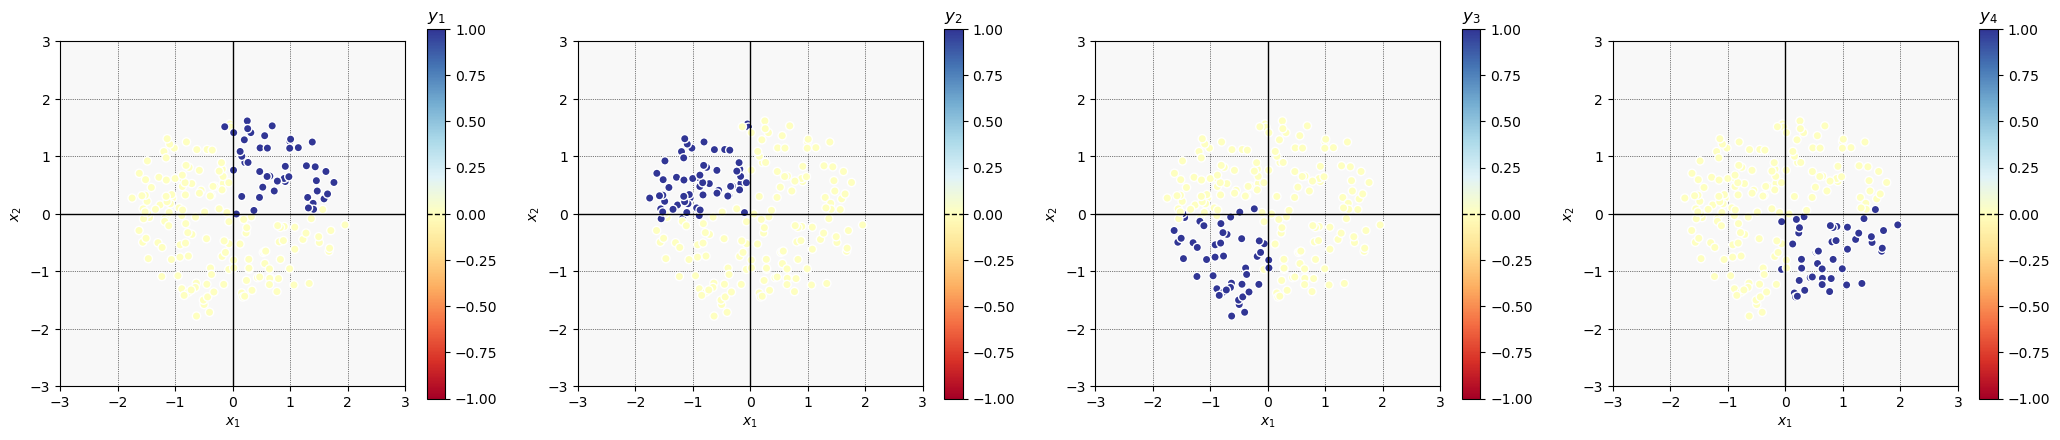

In [4]:
data.scatter(xs, ys)

We kunnen eens beginnen deze data te fitten met een multi-layer perceptron zoals we dat in de vorige les hebben geïmplementeerd. Als activatiefunctie gaan we dit keer voor de afwisseling een softsign-functie gebruiken:

$$
\varphi(a) = \frac{a}{1+|a|}
$$

Voeg die nu eerst toe aan je module met als naam `softsign()`, voor zover je die nog niet geïmplementeerd had.

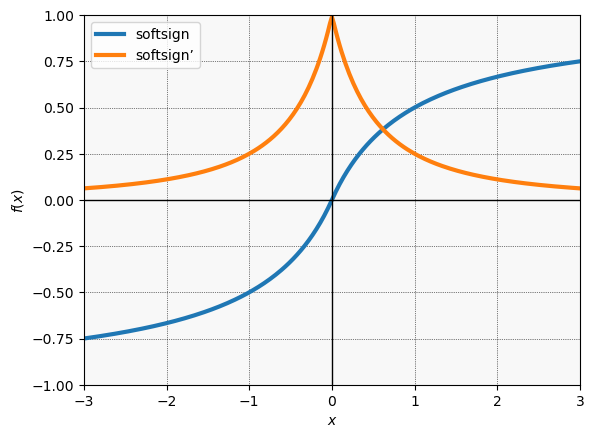

In [5]:
my_activation = activation_functions.softsign
my_gradient = vlearning.derivative(my_activation)
data.graph([my_activation, my_gradient])

We bouwen een neuraal netwerk met slechts één hidden layer met tien neuronen. Dit zijn voor dit probleem redelijke waarden, maar voel je vrij deze aan te passen als jouw model geen bevredigende voorspellingen geeft. De breedte van de invoerlaag *moet* wel op twee gesteld worden en die van de uitvoerlaag *moet* vier zijn. (Waarom?)

Als het goed is werkt het onderstaande model nu "out of the box" met een learning rate `alpha=0.2`. In elke grafiek worden de punten van één klasse geïdentificeerd (in blauw) ten opzichte van de andere (in geel). De voorspellingen van het model (de achtergrondkleur) dienen daar redelijkerwijs mee overeen te komen. Convergeert het model ogenschijnlijk naar een acceptabele oplossing?

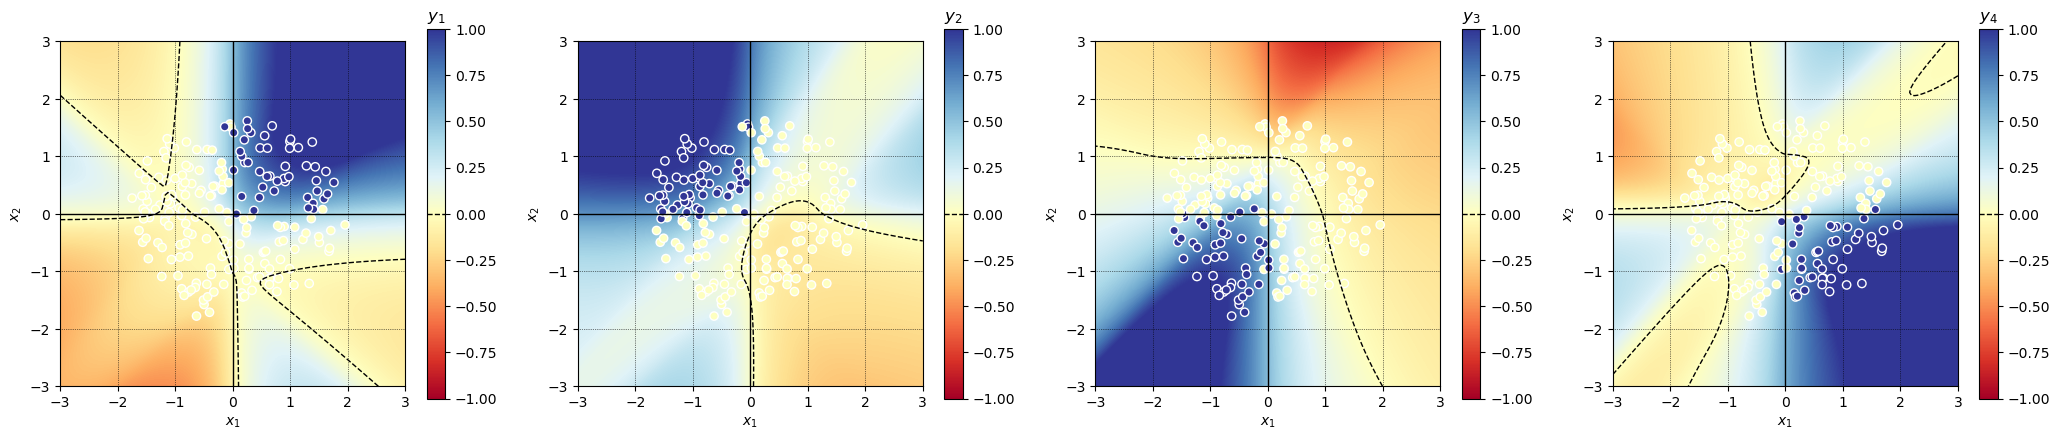

- Loss: 0.20318155853158332


In [6]:
my_network = layers.InputLayer(2)
my_network.add(layers.DenseLayer(10))
my_network.add(layers.ActivationLayer(10, activation=activation_functions.softsign))
my_network.add(layers.DenseLayer(4))
my_network.add(layers.LossLayer())
my_network.fit(xs, ys, alpha=0.2, epochs=200)
data.scatter(xs, ys, model=my_network)
print(f'- Loss: {my_network.evaluate(xs, ys)}')

De uitkomsten van het model hierboven hebben een bereik van 0 (geel) tot +1 (blauw), of vallen daar zelfs nog buiten; negatieve waarden worden oranjerood gekleurd en waarden groter dan één worden donkerblauw geclipt. We kunnen dit zien door naar de voorspellingen $\boldsymbol{\hat{y}}$ te kijken.

In [7]:
yhats = my_network.predict(xs)
DataFrame(xs, columns=['x1', 'x2']).join(DataFrame(yhats, columns=['ŷ1', 'ŷ2', 'ŷ3', 'ŷ4'])).head()

,x1,x2,ŷ1,ŷ2,ŷ3,ŷ4
0,-0.184891,-0.740544,-0.023497,0.024507,0.652296,0.325540
1,-1.488362,0.216874,0.046199,0.790653,0.209330,-0.034489
2,0.994634,1.256348,1.067622,0.116381,-0.178071,0.018163
3,0.533060,-0.670568,0.103327,-0.145831,0.170856,0.782848
4,0.282804,-0.963267,0.022339,-0.112350,0.303655,0.724012


In [8]:
my_softmax = layers.InputLayer(4) + layers.SoftmaxLayer(4) + layers.LossLayer()
print(my_softmax)

InputLayer(num_outputs=4, name='InputLayer_2') +
	SoftmaxLayer(num_outputs=4, name='SoftmaxLayer_1') +
	LossLayer(num_inputs=4, name='LossLayer_2', loss='mean_squared_error')


Nu zal de functie `__call__()` die al het werk doet moeten worden herschreven. Deze ontvangt wederom een lijst met invoerwaarden `xs`, eventueel een lijst met correcte uitkomsten `ys` (als de loss moet worden berekend), en soms een learning rate `alpha` (als gradiënten moeten worden berekend). Tijdens *forward-propagation* berekent de softmax-laag voor elke instance uitvoerwaarden $\hat{y}_{no}$ volgens

$$
\hat{y}_{no} = \frac{e^{x_{no}}}{\sum_i e^{x_{ni}}}
$$

Zoals vanouds loopt de index $n$ over de instances, de index $i$ over de inputs, en de index $o$ over de outputs; voor een softmax-laag is het aantal outputs echter altijd gelijk aan het aantal inputs.

Bereken dus eerst een nieuwe lijst met $e^{x_{no}}$, bepaal hiervan de som, en deel dan alle waarden in die nieuwe lijst door de som. Denk zelf na hoe je dit efficiënt kan aanpakken zonder meermaals identiek dezelfde sommatie uit te hoeven rekenen.

We gebruiken weer het stramien van de `__call__()` methode uit het vorige hoofdstuk. Vul de code hieronder aan. De berekening van de loss en gradienten in `ls` en `gs` mag je voorlopig even negeren, die werken we zometeen uit.

```python
    def __call__(self, xs, ys=None, alpha=None):
        hh = []
        for x in xs:
            h = []
            for o in range(self.outputs):
                # Bereken voor elk neuron o uit de lijst invoerwaarden x de uitvoerwaarde
                ...
                h.append(...)
            hh.append(h)
        yhats, ls, gs = self.next(...)
        return yhats, ls, gs
```

Test dat je functie werkt met de code hieronder waarin $N=1$ instance doorgerekend wordt. Controleer dat de uitkomst voldoet aan alle eisen die aan kansen gesteld mogen worden:

* alle $\hat{y}_{no}$ zijn groter of gelijk aan nul

* de som van alle $\hat{y}_{no}$ van een instance is gelijk aan 1

* hoe hoger $x_{no}$, hoe hoger $\hat{y}_{no}$

Varieer zelf de getallen in de invoer $x_{ni}$ en kijk hoe dit de uitkomsten voor $\hat{y}_{no}$ beïnvloedt.

In [9]:
x = [[-1.0, 4.0, 2.0, 0.0]]
yhat = my_softmax.predict(x)
print('Invoer  =', x)
print('Uitvoer =', yhat)

Invoer  = [[-1.0, 4.0, 2.0, 0.0]]
Uitvoer = [[0.005806628431527065, 0.8617800692577713, 0.11662924976066819, 0.015784052550033668]]


De implementatie die je hebt gekozen heeft waarschijnlijk een hinderlijke tekortkoming: hij is nogal gevoelig voor numerieke *overflow* of *underflow*. De exponentiële functie kan namelijk al gauw leiden tot enorm grote of enorm kleine uitkomsten. Dit kan problemen veroorzaken.

De code hieronder is nagenoeg identiek aan die hierboven, behalve dat alle $x_{ni}$ worden verlaagd met een flinke offset door er -1000 bij op te tellen. Hierdoor worden de waarden $e^{x_{ni}}$ zo klein dat deze worden afgerond naar nul omdat ze niet meer als een floating-point value kunnen worden gerepresenteerd. De som van de waarden is dan ook nul, hetgeen mogelijk leidt tot een `ZeroDivisionError`. Probeer dit maar eens uit hieronder.

In [10]:
offset = -1000.0
x = [[-1.0 + offset, 4.0 + offset, 2.0 + offset, 0.0 + offset]]
yhat = my_softmax.predict(x)
print('Invoer  =', x)
print('Uitvoer =', yhat)

Invoer  = [[-1001.0, -996.0, -998.0, -1000.0]]
Uitvoer = [[0.005806628431527065, 0.8617800692577713, 0.11662924976066819, 0.015784052550033668]]


Het gaat ook mis als de waarden te groot zijn. Verander de offset eens naar `offset = +1000.0` en bekijk wat er dan gebeurt. Mogelijk krijg je een `OverflowError`. Begrijp je wat er in beide gevallen mis gaat?

Dit probleem is te corrigeren door slim met de invoerwaarden om te gaan. De uitkomsten van de softmax-functie zijn eigenlijk alleen afhankelijk van de *verschillen* tussen de invoerwaarden. Ze veranderen niet als alle invoerwaarden met dezelfde waarde worden verhoogd of verlaagd (zoals in de bovenstaande code gedaan werd met de `offset` variabele). Je kan de invoerwaarden naar een bereik verschuiven dat niet leidt tot numerieke under-/overflow door per instance van alle waarden het maximum van de lijst af te trekken, nog voordat je de exponentiële functie toepast. Dit zorgt ervoor dat in de lijst steeds tenminste één waarde voorkomt gelijk aan $x_{ni}=0$, en dat alle andere $x_{ni}$ kleiner zijn. Overtuig jezelf ervan dat dit zowel het overflow als underflow probleem oplost.

Implementeer de beschreven stap en ga na dat daarmee de bovenstaande code wel te draaien is met zowel `offset = -1000.0` als `offset = +1000.0`. Controleer ook dat de uitkomsten voor $\hat{y}_{no}$ identiek zijn aan die uit de vorige cel hierboven. Hiermee is de forward-propagation klaar.

We maken de `SoftmaxLayer()` af door ook de loss en gradienten te back-propageren. De loss kan weer onveranderd worden doorgegeven van de volgende naar de vorige laag. Resteren alleen nog de gradiënten.

De gradiënt van de loss naar de uitvoer $\boldsymbol{\nabla_{\hat{y}}}l_n$ wordt ontvangen van de volgende laag, omgerekend naar de gradiënt van de loss naar de invoer $\boldsymbol{\nabla_{x}}l_n$, en doorgegeven naar de aanroeper als return value. Net als de `ActivationLayer()` heeft de `SoftmaxLayer()` geen modelparameters om bij te werken; de learning rate wordt alleen als functieparameter gebruikt om compatibel te zijn met de andere neurale lagen.

Maak gebruik van de formule

$$
\frac{\partial l_n}{\partial x_{ni}}=\sum_{o}\frac{\partial l_n}{\partial\hat{y}_{no}}\cdot\frac{\partial\hat{y}_{no}}{\partial x_{ni}}=\sum_{o}\frac{\partial l_n}{\partial\hat{y}_{no}}\cdot\hat{y}_{no}\cdot\left(\delta_{io}-\hat{y}_{ni}\right)
$$

om de gradiënt van de loss naar de invoer te berekenen en te retourneren; deze uitdrukking combineert de formules uit paragraaf 4.2 van de Syllabus.

<div class="alert alert-info">

**Opmerking:**

De Kronecker-delta $\delta_{io}$ kun je in Python desgewenst uitdrukken als `(i == o)`; dit levert een boolean op, maar deze wordt bij berekeningen automatisch gecast naar een waarde gelijk aan 0 (voor `False`) of 1 (voor `True`).

</div>

Als je deze code werkend hebt gekregen kun je als het goed is hieronder de eerdere dataset fitten met een model inclusief een softmax laag. Komen de fits redelijk overeen met de verdeling van de datapunten? Oogt de oplossing even goed of zelfs beter dan het vergelijkbare regressiemodel zonder softmax-laag eerder hierboven? Is de gemiddelde loss per instance gewijzigd?

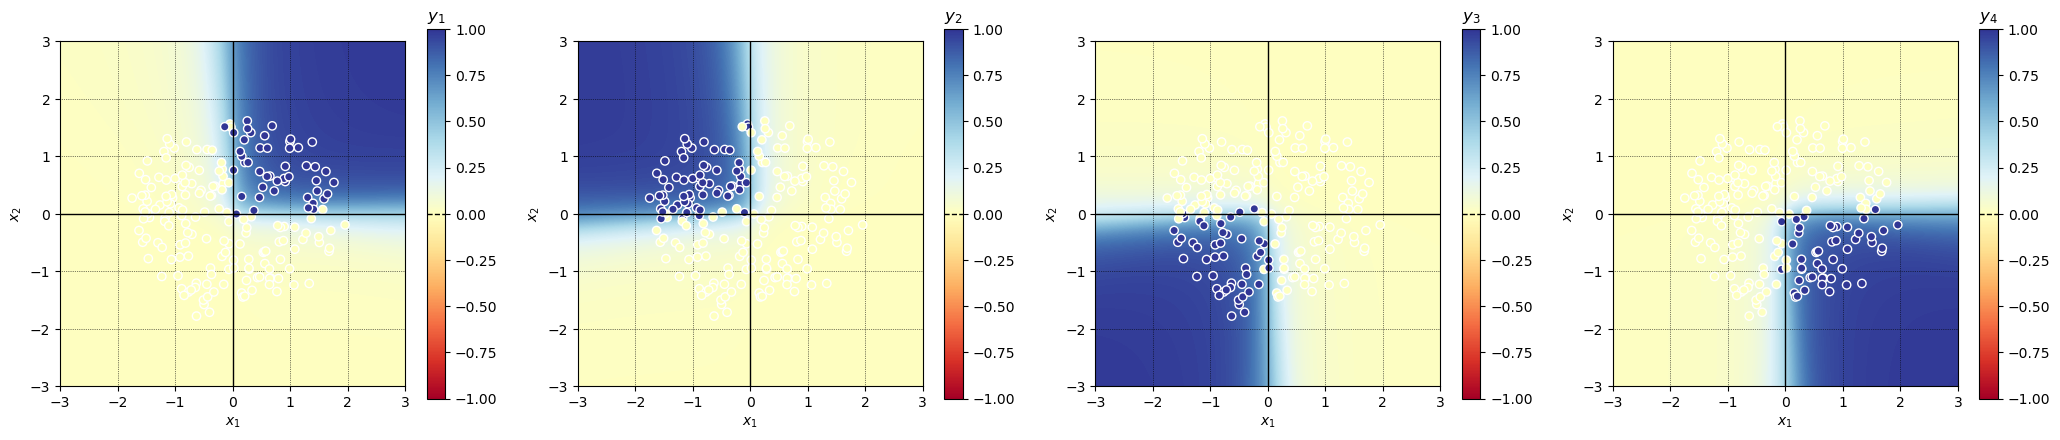

- Loss: 0.12747532327956818


In [11]:
my_network = layers.InputLayer(2)
my_network.add(layers.DenseLayer(10))
my_network.add(layers.ActivationLayer(10, activation=activation_functions.softsign))
my_network.add(layers.DenseLayer(4))
my_network.add(layers.SoftmaxLayer(4))
my_network.add(layers.LossLayer())
my_network.fit(xs, ys, alpha=0.2, epochs=200)
data.scatter(xs, ys, model=my_network)
print(f'- Loss: {my_network.evaluate(xs, ys)}')

We kunnen hieronder ook naar de getalwaarden kijken die als voorspellingen geretourneerd worden. Is nu de uitvoer van je model wel te interpreteren als een kans? Dat wil zeggen, zijn de voorspellingen voor alle klassen altijd groter dan nul, en tellen ze op tot één?

In [12]:
yhats = my_network.predict(xs)
DataFrame(xs, columns=['x1', 'x2']).join(DataFrame(yhats, columns=['ŷ1', 'ŷ2', 'ŷ3', 'ŷ4'])).head()

,x1,x2,ŷ1,ŷ2,ŷ3,ŷ4
0,-0.184891,-0.740544,0.010658,0.044910,0.695262,0.249170
1,-1.488362,0.216874,0.012574,0.819125,0.163603,0.004698
2,0.994634,1.256348,0.938223,0.040516,0.000706,0.020554
3,0.533060,-0.670568,0.042615,0.007146,0.082594,0.867645
4,0.282804,-0.963267,0.020912,0.008611,0.182037,0.788440


<div class="alert alert-success">

**Gefeliciteerd!**

Je hebt nu een volwaardige softmax-laag toegevoegd aan je virtuele neurale gereedschapskist.

</div>

### <a id='Cross_entropy'>Cross-entropy</a>

De *cross-entropy* loss-functie kan gebruikt worden om de saturatie die op kan treden in de softmax layer tegen te gaan. Het functievoorschrift luidt

$$
\mathcal{L}\left(\hat{y}_{no};y_{no}\right)=-y_{no}\cdot\ln\left(\hat{y}_{no}\right)
$$

We hebben hier gebruik gemaakt van de natuurlijke logaritme $\ln\left(x\right)$.

Als er slechts precies twee klassen zijn wordt ook wel de onderstaande versie gebruikt

$$
\mathcal{L}\left(\hat{y}_{no};y_{no}\right)=-y_{no}\cdot\ln\left(\hat{y}_{no}\right)-\left(1-y_{no}\right)\cdot\ln\left(1-\hat{y}_{no}\right)
$$

Deze tweede versie is geschikt als er maar één uitkomst voorspeld wordt door het model, namelijke de kans $\hat{y}_{n1}$ op de eerste klasse. De kans op de andere klasse is dan immers per definitie $\hat{y}_{n2} = 1-\hat{y}_{n1}$, omdat er maar twee klassen zijn, en hoeft dan niet per se als aparte uitvoer gedefinieerd te worden. Dit is gebruikelijk bij logistische regressie, waarbij dan wel een logistische functie als laatste activatiefunctie moet worden gebruikt in plaats van een softmax-laag.

Implementeer de cross-entropy volgens beide definities in de vorm van een tweetal functies `categorical_crossentropy(yhat, y)` en `binary_crossentropy(yhat, y)`, respectievelijk. Plot de grafieken hieronder. Controleer dat de functie correct werkt voor zowel instances met het werkelijke klasselabel $y_{no}=1$ als voor $y_{no}=0$.

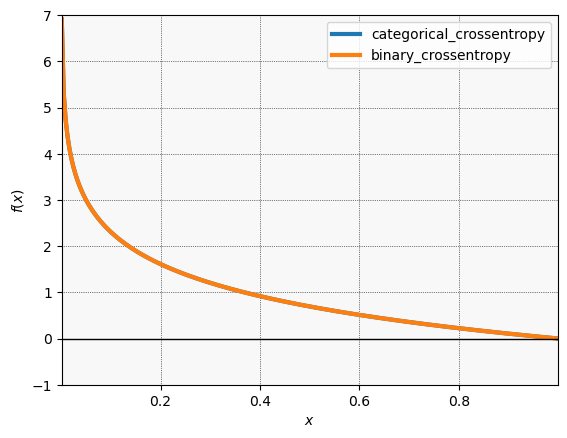

In [13]:
y = 1.0
data.graph([loss_functions.categorical_crossentropy, loss_functions.binary_crossentropy], y, xlim=(0.001, 0.999))

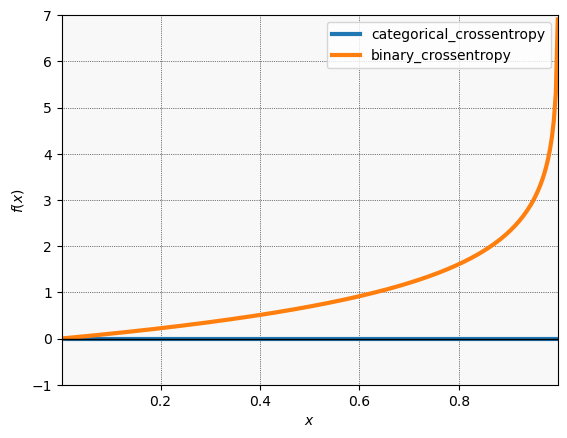

In [14]:
y = 0.0
data.graph([loss_functions.categorical_crossentropy, loss_functions.binary_crossentropy], y, xlim=(0.001, 0.999))

In de bovenstaande grafiek is een parameter `xlim=(0.001, 0.999)` meegegeven. Probeer eens uit wat er vermoedelijk misgaat hierboven als je die niet mee zou geven.

Het probleem van de logaritmische functie is dat $\ln\left(x\right)$ alleen maar gedefinieerd is voor $x>0$. De waarde van $\hat{y}_{no}$ kan in theorie weliswaar nooit helemaal nul worden omdat de softmax-functie altijd een uitkomst tussen nul en één oplevert. Maar in de praktijk kan dit door afronding en underflow wel het geval blijken.  Numerieke differentiatie van de loss-functie verergert het probleem nog verder omdat we dan in een kleine omgeving rondom een zekere $x$ moeten kijken, waardoor we zelfs negatieve functie-argumenten kunnen krijgen! Dan gaat het toepassen van de logaritme mis.

Een workaround kan worden gegeven door een "pseudo-logaritmische" functie te schrijven die nabij $x=0$ een aangepaste uitkomst geeft. Een mogelijkheid is bijvoorbeeld te kiezen voor 

$$
\text{pseudo-ln}\left(x\right)=\left\{ \begin{array}{c}
\ln\left(x\right)\text{ voor }x\geq\varepsilon\\
\ln\left(\varepsilon\right)+\frac{x-\varepsilon}{\varepsilon}\text{ voor }x<\varepsilon
\end{array}\right.
$$

waarbij $\varepsilon$ een klein getal is. Hierbij wordt de asymptotische staart van de logaritme vervangen door een steile rechte lijn. De bovenstaande definitie is zo gekozen dat beide stukken functie gladjes op elkaar aansluiten nabij $x=\varepsilon$.

Pas je definities van de cross-entropie aan opdat deze gebruikt maakt van deze "pseudo-logaritme". Verifieer dat de onderstaande code zonder foutmeldingen werkt. Speel met de waarde van $\varepsilon$ en probeer de vorm van de grafieken te begrijpen.

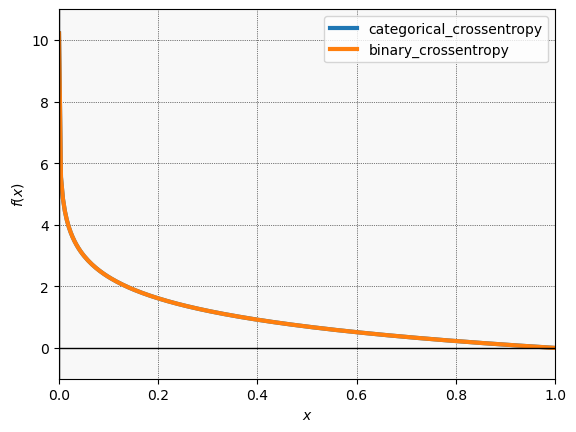

In [15]:
y = 1.0
data.graph([loss_functions.categorical_crossentropy, loss_functions.binary_crossentropy], y, xlim=(0.0, 1.0))

We hebben nu alle ingrediënten om het eerdere neurale netwerk gebruik te laten maken van de cross-entropy loss-functie. Draai de code hieronder om te testen of dit naar behoren werkt. Beoordeel opnieuw of de oplossing even goed of zelfs beter oogt dan het vergelijkbare model zonder cross-entropy loss-functie hierboven, en of dit herkenbaar is in de gemiddelde loss per instance.

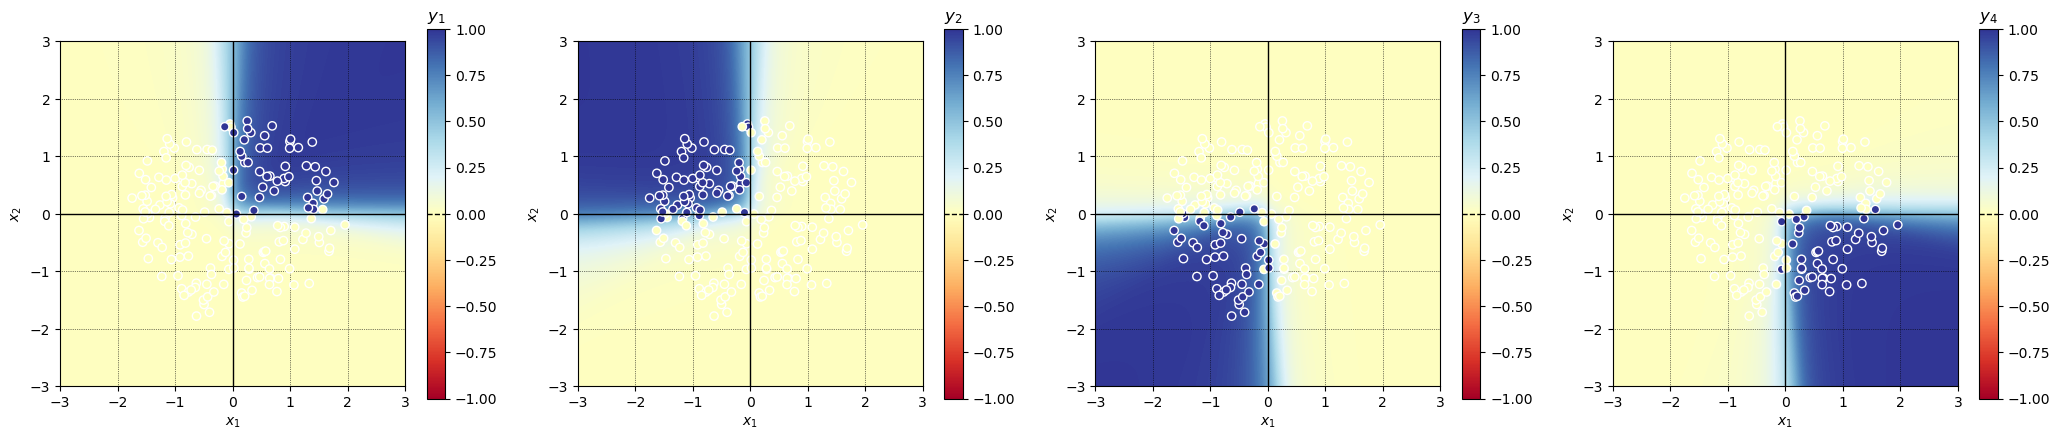

- Loss: 0.2111847097404792


In [16]:
my_network = layers.InputLayer(2)
my_network.add(layers.DenseLayer(10))
my_network.add(layers.ActivationLayer(10, activation=activation_functions.softsign))
my_network.add(layers.DenseLayer(4))
my_network.add(layers.SoftmaxLayer(4))
my_network.add(layers.LossLayer(loss=loss_functions.categorical_crossentropy))
my_network.fit(xs, ys, alpha=0.2, epochs=200)
data.scatter(xs, ys, model=my_network)
print(f'- Loss: {my_network.evaluate(xs, ys)}')

Tenslotte breiden we de verzameling activatiefuncties nog iets verder uit met in elk geval de *logistische* (`sigmoid`), de *softplus* (`softplus`), de *rectified linear unit* (`relu`) en de *sigmoid-weighted linear unit* oftewel *swish* (`swish`) functies. Zoek hiervan zelf de definities op. Hieronder worden ze allemaal getoond.

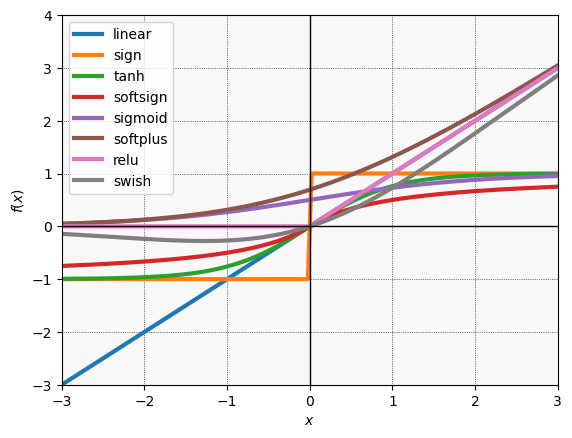

In [17]:
my_activations = [
    activation_functions.linear,
    activation_functions.sign,
    activation_functions.tanh,
    activation_functions.softsign,
    activation_functions.sigmoid,
    activation_functions.softplus,
    activation_functions.relu,
    activation_functions.swish
]
data.graph(my_activations)

Houd in je functie-definities ook weer rekening met mogelijke under- en overflow. Lukt het je om de hele onderstaande tabel correct te evalueren?

In [18]:
my_arguments =  [-1000, -1, 0, 1, 1000]
my_table = [[φ(a) for a in my_arguments] for φ in my_activations]
my_columns = [f'φ({a})' for a in my_arguments]
my_rows = [φ.__name__ for φ in my_activations]
DataFrame(my_table, columns=my_columns).set_index(array(my_rows))

,φ(-1000),φ(-1),φ(0),φ(1),φ(1000)
linear,-1000.000000,-1.000000,0.000000,1.000000,1000.000000
sign,-1.000000,-1.000000,0.000000,1.000000,1.000000
tanh,-1.000000,-0.761594,0.000000,0.761594,1.000000
softsign,-0.999001,-0.500000,0.000000,0.500000,0.999001
sigmoid,0.000000,0.268941,0.500000,0.731059,1.000000
softplus,0.000000,0.313262,0.693147,1.313262,1000.000000
relu,0.000000,0.000000,0.000000,1.000000,1000.000000
swish,-0.000000,-0.268941,0.000000,0.731059,1000.000000


Hieronder wordt ter afsluiting de dataset van het *XOR*-probleem nogmaals gefit. Zoals zo vaak wanneer je data-analyses uitvoert moeten we eerst wat preprocessing doen. De klasselabels werden in het vorige hoofdstuk namelijk aangeleverd als waarden $y=\pm1$, maar we willen die hebben in de vorm van een one-hot encoding. Ga na dat je begrijpt hoe de onderstaande code deze omzetting bewerkstelligt.

In [19]:
xs, ys = data.xorproblem(num=200, noise=0.8)
ys = [[1.0, 0.0] if y == [1.0] else [0.0, 1.0] for y in ys]
DataFrame(xs, columns=['x1', 'x2']).join(DataFrame(ys, columns=['y1', 'y2'])).head()

,x1,x2,y1,y2
0,-1.296895,-1.153010,0.0,1.0
1,1.627500,-1.510327,1.0,0.0
2,-1.005526,0.631675,1.0,0.0
3,0.343610,1.598089,0.0,1.0
4,-1.762399,-1.243301,0.0,1.0


Dit keer gebruiken we relu-activatiefuncties in een hidden layer met breedte tien, en voegen we de softmax-laag en cross-entropy loss-functie toe om het probleem volledig netjes als classificatieprobleem op te lossen.

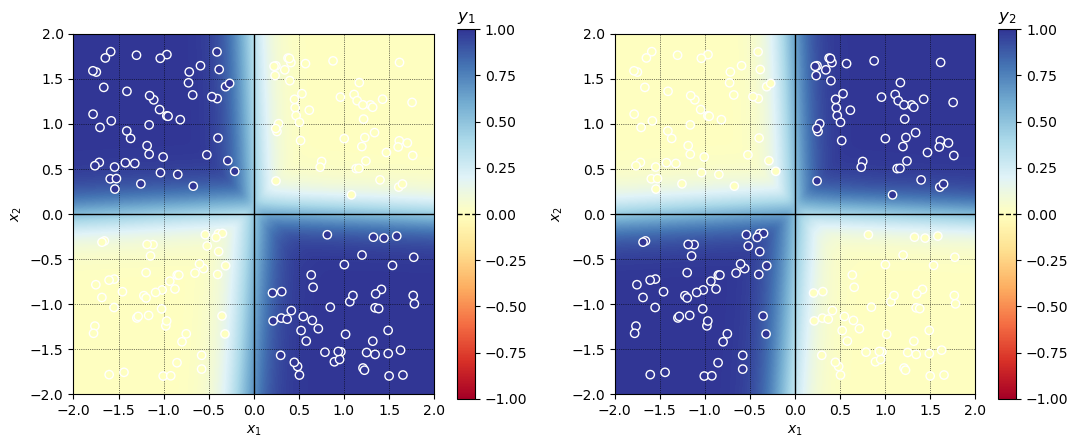

- Loss: 0.03502504942358958


In [20]:
my_network = layers.InputLayer(2)
my_network.add(layers.DenseLayer(10))
my_network.add(layers.ActivationLayer(10, activation=activation_functions.relu))
my_network.add(layers.DenseLayer(2))
my_network.add(layers.SoftmaxLayer(2))
my_network.add(layers.LossLayer(loss=loss_functions.categorical_crossentropy))
my_network.fit(xs, ys, alpha=0.2, epochs=200)
data.scatter(xs, ys, model=my_network)
print(f'- Loss: {my_network.evaluate(xs, ys)}')

Mooi toch? Laten we dit voor de volledigheid eens naast het overeenkomstige `tensorflow` netwerk leggen. Eerst zetten we de data om naar een `numpy` array.

In [21]:
krs_xs, krs_ys = array(xs), array(ys)

Hierna kunnen we met een redelijk vergelijkbare syntax als voor onze eigen module het neurale netwerk opzetten, compileren, trainen, en toepassen. In dit geval hebben we geen speciale softmax-laag, maar kan de softmax-functie als activatiefunctie aan een `Activation()` layer worden meegegeven; `tensorflow.keras` kent ook standaard al een `CategoricalCrossentropy()` loss-functie die we kunnen gebruiken.

521/521 [==============================] - 0s 294us/step


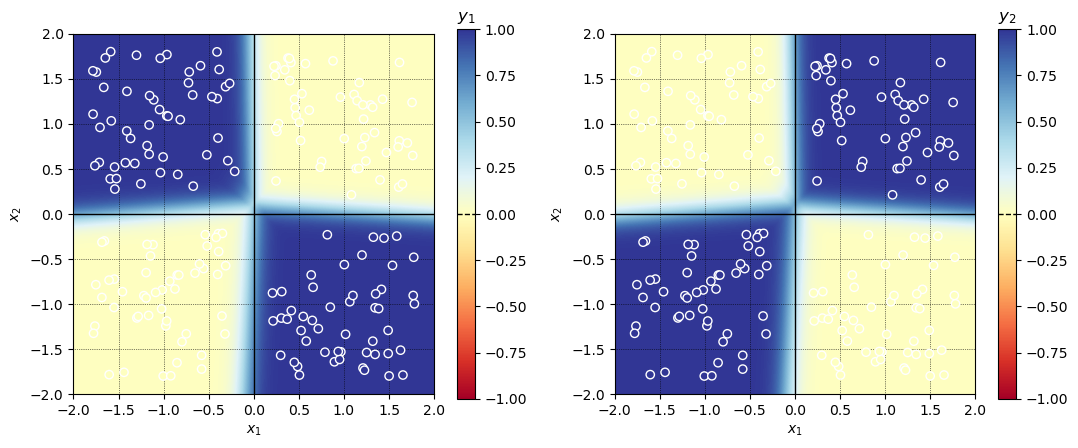

- Loss: 0.003789416281506419


In [22]:
krs_network = keras.models.Sequential()
krs_network.add(keras.layers.InputLayer(input_shape=(2, )))
krs_network.add(keras.layers.Dense(10))
krs_network.add(keras.layers.Activation(activation=keras.activations.relu))
krs_network.add(keras.layers.Dense(2))
krs_network.add(keras.layers.Activation(activation=keras.activations.softmax))
krs_network.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.SGD(learning_rate=0.2))
krs_network.fit(krs_xs, krs_ys, verbose=0, epochs=200)
data.scatter(krs_xs, krs_ys, model=krs_network)
print(f'- Loss: {krs_network.evaluate(krs_xs, krs_ys, verbose=0)}')

<div class="alert alert-success">

**Gefeliciteerd!**

Je bent nu in staat om met je eigen neurale netwerk naast niet-linaire regressie-problemen ook niet-lineaire multinomiale classificatie-problemen aan te pakken op een wijze die ogenschijnlijk niet onderdoet voor veelgebruikte deep-learning modules.

</div>

***

<small>&copy; 2024, Dave R.M. Langers, [d.r.m.langers@pl.hanze.nl](mailto:d.r.m.langers@pl.hanze.nl)</small>